In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

from sklearn.datasets import fetch_covtype
from numpy.random import default_rng
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

In [2]:
columns = ["pregnant", "glucose", "BP", "skin_thick", "insulin", "BMI", "diab_ped_func", "age", "diabetes"]

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv", names=columns)

In [4]:
data.describe()

,pregnant,glucose,BP,skin_thick,insulin,BMI,diab_ped_func,age,diabetes
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
cols_missing = ["glucose", "BP", "skin_thick", "insulin", "BMI"]

In [6]:
data[cols_missing] = data[cols_missing].replace(0, np.nan)

In [7]:
data.isna().sum()

pregnant           0
glucose            5
BP                35
skin_thick       227
insulin          374
BMI               11
diab_ped_func      0
age                0
diabetes           0
dtype: int64

In [8]:
X = data.iloc[:,:8]
y = data.iloc[:,8]

In [9]:
X.isna().mean()

pregnant         0.000000
glucose          0.006510
BP               0.045573
skin_thick       0.295573
insulin          0.486979
BMI              0.014323
diab_ped_func    0.000000
age              0.000000
dtype: float64

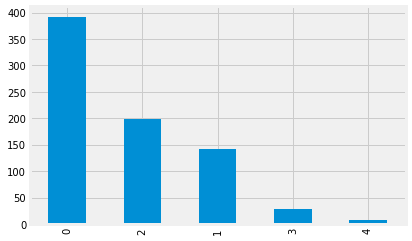

In [10]:
X[cols_missing].isna().sum(axis=1).value_counts().plot(kind="bar")
plt.show()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
X_missing_tag = X_train[cols_missing].isna()

In [13]:
X_missing_tag.columns = [f"{c}_missing" for c in cols_missing]

In [14]:
X_missing_tag.head()

,glucose_missing,BP_missing,skin_thick_missing,insulin_missing,BMI_missing
353,False,False,False,False,False
711,False,False,False,False,False
373,False,False,False,False,False
46,False,False,True,True,False
682,False,False,False,False,False


In [15]:
def model_eval(model, X, y):
    y_pred = model.predict_proba(X)[:, 1]
    print(f"ROC-AUC: {roc_auc_score(y, y_pred)}")

In [16]:
lr = LogisticRegressionCV(scoring="accuracy")

lr.fit(X_missing_tag, y_train)
lr.score(X_missing_tag, y_train)

model_eval(lr, X_missing_tag, y_train)

ROC-AUC: 0.5232827102803738


In [17]:
model = GradientBoostingClassifier(random_state=42,
                                   max_depth = 2,
                                   n_estimators=20
                                   )


In [18]:
# Drop NA rows
data_drop_rows = data.dropna(axis=0)
X_drop_rows = data_drop_rows.iloc[:,:8]
y_drop_rows = data_drop_rows.iloc[:,8]
X_drop_rows.shape

(392, 8)

In [19]:
model.fit(X_drop_rows, y_drop_rows)
model_eval(model, X_drop_rows, y_drop_rows)

ROC-AUC: 0.9049324721080447


In [20]:
# Drop NA columns
data_drop_cols = data.dropna(axis=1)
X_drop_cols = data_drop_cols.drop("diabetes", axis=1)
y_drop_cols = data_drop_cols["diabetes"]
X_drop_cols.shape

(768, 3)

In [21]:
model.fit(X_drop_cols, y_drop_cols)
model_eval(model, X_drop_cols, y_drop_cols)

ROC-AUC: 0.758794776119403


In [22]:
# Impute with mean or median
imptr = SimpleImputer(strategy="mean", add_indicator=False)

In [23]:
X_train_mean_imp = imptr.fit_transform(X_train)
X_test_mean_imp = imptr.transform(X_test)

In [24]:
model.fit(X_train_mean_imp, y_train)
model_eval(model, X_test_mean_imp, y_test)

ROC-AUC: 0.8037037037037036


In [25]:
imptr = SimpleImputer(strategy="median", add_indicator=False)

In [26]:
X_train_med_imp = imptr.fit_transform(X_train)
X_test_med_imp = imptr.transform(X_test)

In [27]:
model.fit(X_train_med_imp, y_train)
model_eval(model, X_test_med_imp, y_test)

ROC-AUC: 0.8037037037037036


In [28]:
# Iterative imputer
it_imputer = IterativeImputer(max_iter=10, random_state=42)
X_train_it_imp = it_imputer.fit_transform(X_train)
X_test_it_imp = it_imputer.transform(X_test)

In [29]:
model.fit(X_train_it_imp, y_train)
model_eval(model, X_test_it_imp, y_test)

ROC-AUC: 0.7957407407407406


In [30]:
# KNN imputer
knn_imputer = KNNImputer()
X_train_knn_imp = knn_imputer.fit_transform(X_train)
X_test_knn_imp = knn_imputer.transform(X_test)

In [31]:
model.fit(X_train_knn_imp, y_train)
model_eval(model, X_test_knn_imp, y_test)

ROC-AUC: 0.8158333333333333
